# Support Vector Machine

In [1]:
from sklearn.svm import SVR, SVC
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_recall_fscore_support
)
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


In [2]:
problem_types = ['classification','regression'] #regression or classification
input_types = ["correlation_variance_filter","random_forest_elimination","PCA","Factor_Analysis","genetic_algorithm"] #reduced features: , genetic_algorithm, PCA, Factor_Analysis, random_forest
seed = 254

In [3]:
def read_file(problem_type, input_file):
    """
    Read input features and recover target values (IC50 or Potency).

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_file (str): Path to the input feature file.

    Returns:
        tuple:
            - X_indexed (pd.DataFrame): Feature DataFrame indexed by 'Molecule ChEMBL ID'.
            - target (pd.Series): Target values indexed by 'Molecule ChEMBL ID'.
    """
    if problem_type not in {'regression', 'classification'}:
        raise ValueError("Invalid problem_type. Must be 'regression' or 'classification'.")

    target_column = '-logIC50' if problem_type == 'regression' else 'Potency'

    # Load features and target data
    X = pd.read_csv(input_file)
    target = pd.read_csv('../../3_train_test_split/descriptors_all.csv', usecols=['Molecule ChEMBL ID', target_column])
    
    # Ensure correct merging without data loss
    merged = pd.merge(X, target, on='Molecule ChEMBL ID', how='inner')

    # Return the feature DataFrame and target Series
    return merged.drop(columns=target_column).set_index('Molecule ChEMBL ID'), merged[target_column]


In [4]:
def run_svm(problem_type, input_type, seed):
    """
    Train an SVM model for regression or classification using 5-fold cross-validation.

    Parameters:
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme directory.
        seed (int): Random seed for reproducibility.

    Returns:
        dict: Best model, test predictions, evaluation metrics, and test dataset.
    """
    base_dir = f"../../4_feature_selection/{input_type}/"
    if input_type == "PCA":
        base_dir = os.path.join(base_dir, "PCA_results/PCA_components/")
    elif input_type == "Factor_Analysis":
        base_dir = os.path.join(base_dir, "FA_results/selected_features/")
    elif input_type == "genetic_algorithm":
        base_dir = os.path.join(base_dir, "xgboost/")

    file_suffix = "reg" if problem_type == "regression" else "class"
    test_file = os.path.join(base_dir, f"test_{file_suffix}.csv")

    # Load test dataset
    X_test, y_test = read_file(problem_type, test_file)

    # Initialize SVM and hyperparameter grid
    if problem_type == "regression":
        model = SVR()
        scoring = 'neg_mean_squared_error'
        param_distributions = {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.1, 0.2, 0.5],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    elif problem_type == "classification":
        model = SVC(probability=True, class_weight="balanced", random_state=seed)
        scoring = "accuracy"
        param_distributions = {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }
    else:
        raise ValueError("Invalid problem_type. Choose 'regression' or 'classification'.")

    print(f"Running 5-fold cross-validation for SVM ({problem_type})...")

    best_models = []
    fold_metrics = []

    # Initialize LabelEncoder for classification
    label_encoder = LabelEncoder() if problem_type == "classification" else None

    for fold in range(1, 6):
        train_file = os.path.join(base_dir, f"train_{file_suffix}_{fold}.csv")
        val_file = os.path.join(base_dir, f"val_{file_suffix}_{fold}.csv")

        X_train, y_train = read_file(problem_type, train_file)
        X_val, y_val = read_file(problem_type, val_file)

        if problem_type == "classification":
            # Fit on combined training and validation labels to handle unseen classes
            all_labels = np.concatenate([y_train, y_val, y_test])
            label_encoder.fit(all_labels)

            y_train = label_encoder.transform(y_train)
            y_val = label_encoder.transform(y_val)
            y_test_encoded = label_encoder.transform(y_test)
        else:
            y_test_encoded = y_test

        # Perform hyperparameter tuning
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            n_iter=20,
            scoring=scoring,
            cv=3,
            n_jobs=-1,
            verbose=1,
            random_state=seed,
        )
        random_search.fit(X_train, y_train)

        best_model = random_search.best_estimator_
        best_models.append(best_model)

        y_val_pred = best_model.predict(X_val)
        metric = (mean_squared_error(y_val, y_val_pred) 
                  if problem_type == "regression" else 
                  accuracy_score(y_val, y_val_pred))

        fold_metrics.append(metric)
        print(f"Fold {fold} - Best Model Metric: {metric:.4f}")

    avg_metric = np.mean(fold_metrics)
    print(f"Average Cross-Validation Metric: {avg_metric:.4f}")

    # Evaluate the best model on the test set
    best_index = np.argmin(fold_metrics) if problem_type == "regression" else np.argmax(fold_metrics)
    final_model = best_models[best_index]
    y_test_pred = final_model.predict(X_test)

    test_metric = (mean_squared_error(y_test_encoded, y_test_pred) 
                   if problem_type == "regression" else 
                   accuracy_score(y_test_encoded, y_test_pred))
    print(f"Test Metric: {test_metric:.4f}")

    evaluate_model(final_model, X_test, y_test_encoded, problem_type, input_type, "SVM", label_encoder)

    return {
        'best_model': final_model,
        'test_predictions': y_test_pred,
        'test_metric': test_metric,
        'X_test': X_test,
        'y_test': y_test_encoded
    }


In [5]:
def evaluate_model(final_model, X_test, y_test, problem_type, input_type, model_type, label_encoder=None):
    """
    Evaluate the trained model, create plots, and save evaluation metrics.

    Parameters:
        final_model: Trained model.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): True target values.
        problem_type (str): 'regression' or 'classification'.
        input_type (str): Feature reduction scheme.
        model_type (str): Model type.
        label_encoder (LabelEncoder, optional): Encodes/decodes target labels.

    Returns:
        None
    """
    file_prefix = f"{model_type}_{problem_type}_{input_type}"
    y_pred = final_model.predict(X_test)

    if problem_type == "regression":
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save results
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "mse": mse,
            "r2_score": r2
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True IC50": y_test,
            "Predicted IC50": y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        # Plot predicted vs target
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
        plt.xlabel("True IC50")
        plt.ylabel("Predicted IC50")
        plt.title("Predicted vs True")
        plt.savefig(f"{file_prefix}_predicted_vs_true.png")
        plt.show()

    elif problem_type == "classification":
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

        # Save results
        performance_summary = pd.DataFrame([{
            "model_type": model_type,
            "problem_type": problem_type,
            "input_type": input_type,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }])
        performance_summary.to_csv(f"{file_prefix}_performance_summary.csv", index=False)

        predictions = pd.DataFrame({
            "Molecule ChEMBL ID": X_test.index,
            "True Potency": label_encoder.inverse_transform(y_test) if label_encoder else y_test,
            "Predicted Potency": label_encoder.inverse_transform(y_pred) if label_encoder else y_pred
        })
        predictions.to_csv(f"{file_prefix}_predictions.csv", index=False)

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_ if label_encoder else None)
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.savefig(f"{file_prefix}_confusion_matrix.png")
        plt.show()

        if hasattr(final_model, "predict_proba"):
            y_proba = final_model.predict_proba(X_test)
            for i, class_label in enumerate(label_encoder.classes_ if label_encoder else range(len(y_proba[0]))):
                fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="red", linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend()
            plt.savefig(f"{file_prefix}_roc_curve.png")
            plt.show()

## Train and Evaluate Model

Training SVM model for classification using correlation_variance_filter features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.8095
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.8286
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.7143
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.7500
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.7308
Average Cross-Validation Metric: 0.7666
Test Metric: 0.7863


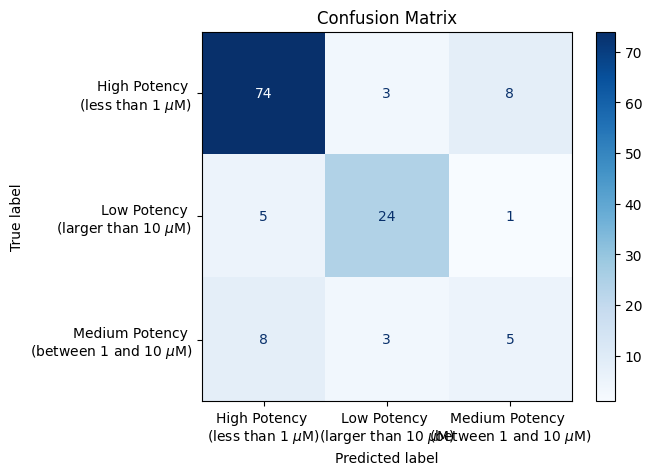

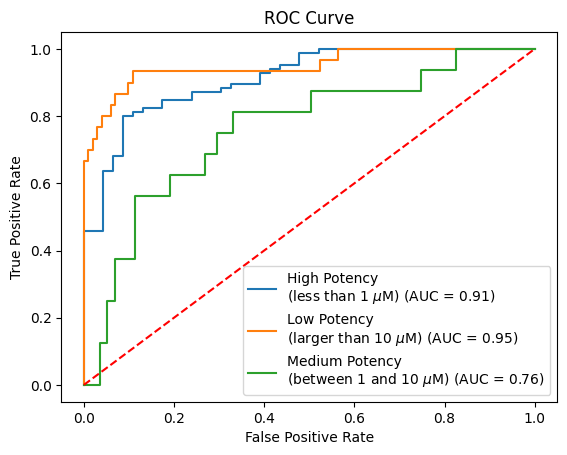

Training and evaluation complete
Training SVM model for regression using correlation_variance_filter features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 3.6871
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 3.2091
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 3.7650
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 3.8959
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 4.7118
Average Cross-Validation Metric: 3.8538
Test Metric: 3.7452


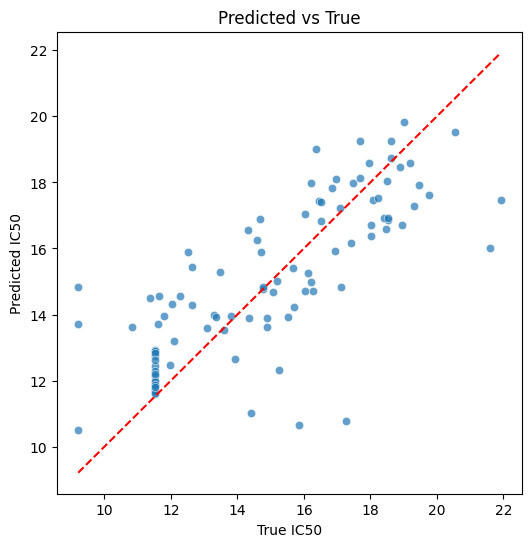

Training and evaluation complete
Training SVM model for classification using random_forest_elimination features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.8000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.7810
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.7143
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.7019
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.7788
Average Cross-Validation Metric: 0.7552
Test Metric: 0.7252


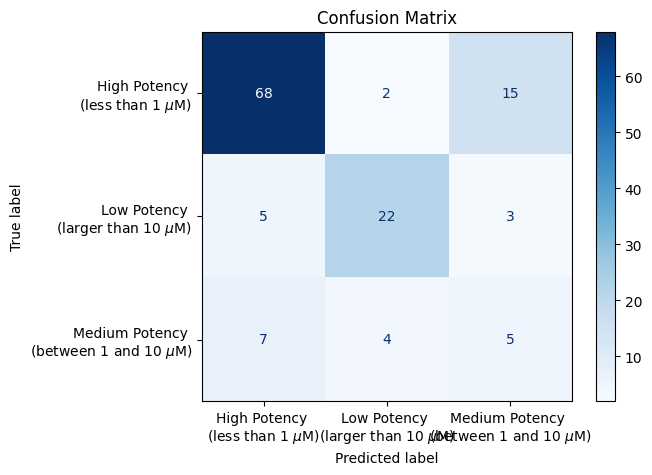

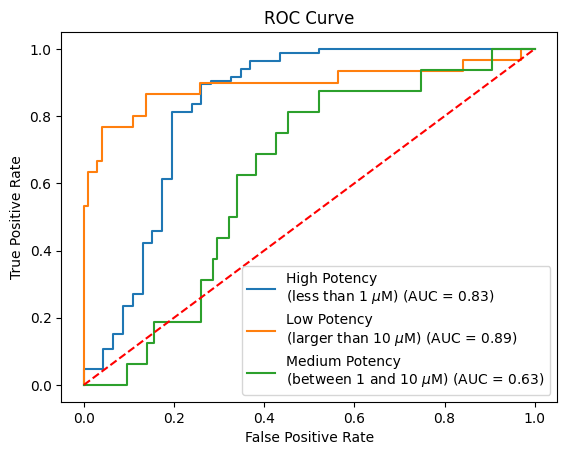

Training and evaluation complete
Training SVM model for regression using random_forest_elimination features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 4.0600
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 3.0221
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 3.3799
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 3.7249
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 4.6074
Average Cross-Validation Metric: 3.7589
Test Metric: 3.2313


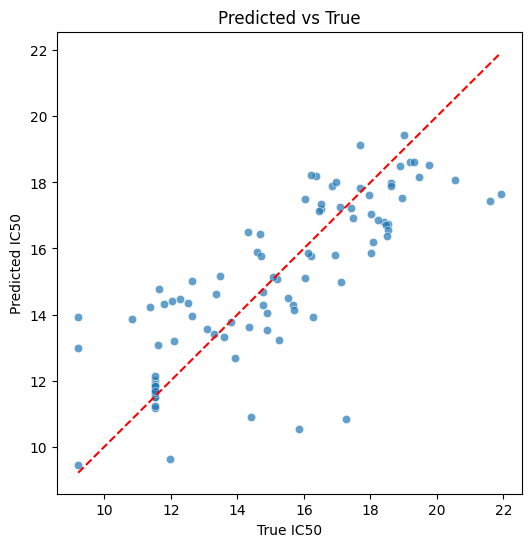

Training and evaluation complete
Training SVM model for classification using PCA features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.7810
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.7238
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.7238
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.7692
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.7115
Average Cross-Validation Metric: 0.7419
Test Metric: 0.7328


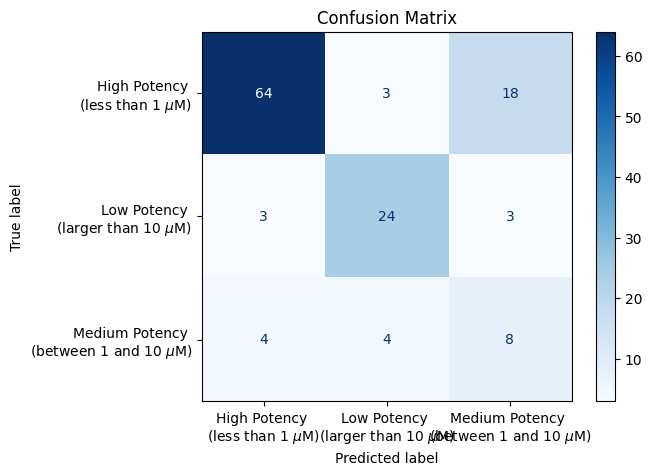

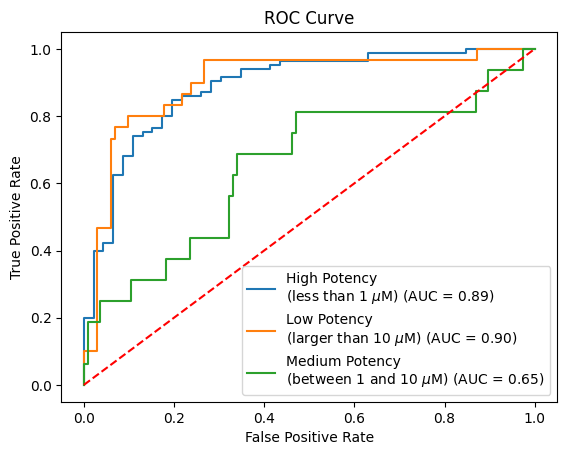

Training and evaluation complete
Training SVM model for regression using PCA features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 4.1106
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 3.6226
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 3.9634
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 4.5597
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 4.3381
Average Cross-Validation Metric: 4.1189
Test Metric: 3.5483


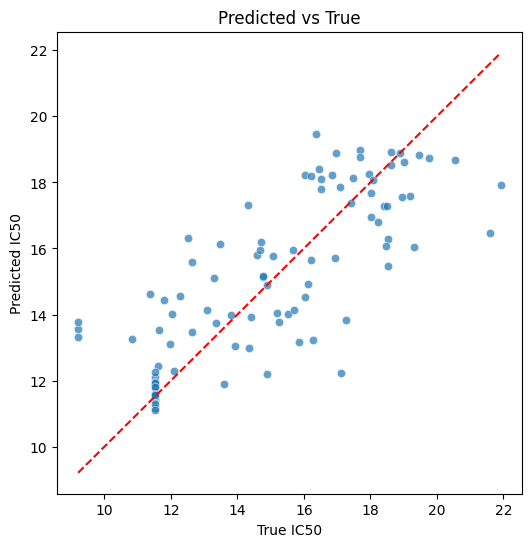

Training and evaluation complete
Training SVM model for classification using Factor_Analysis features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.8000
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.7524
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.6571
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.7885
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.7308
Average Cross-Validation Metric: 0.7458
Test Metric: 0.7557


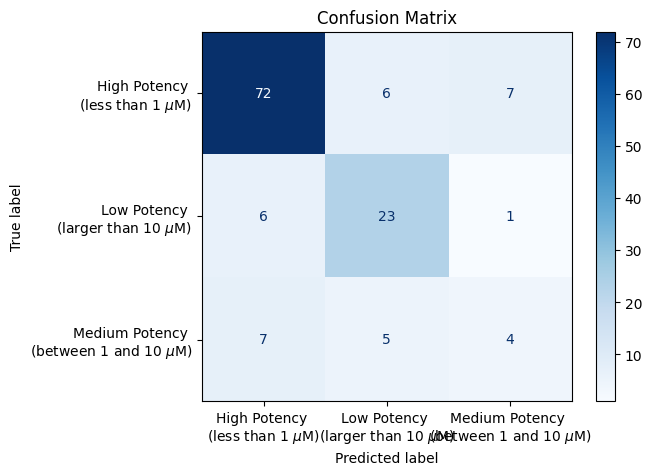

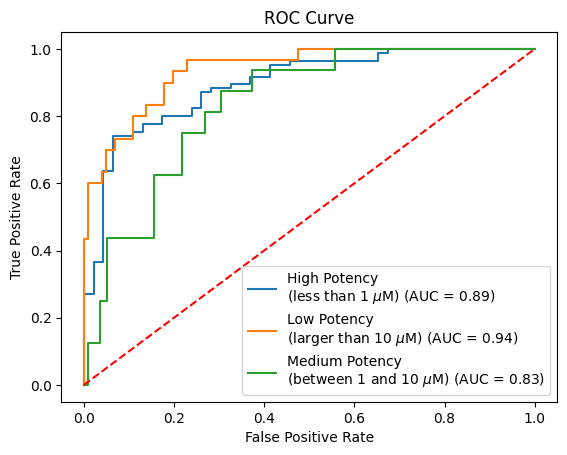

Training and evaluation complete
Training SVM model for regression using Factor_Analysis features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 4.2798
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 3.8359
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 3.6701
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 4.3954
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 4.8912
Average Cross-Validation Metric: 4.2145
Test Metric: 3.9124


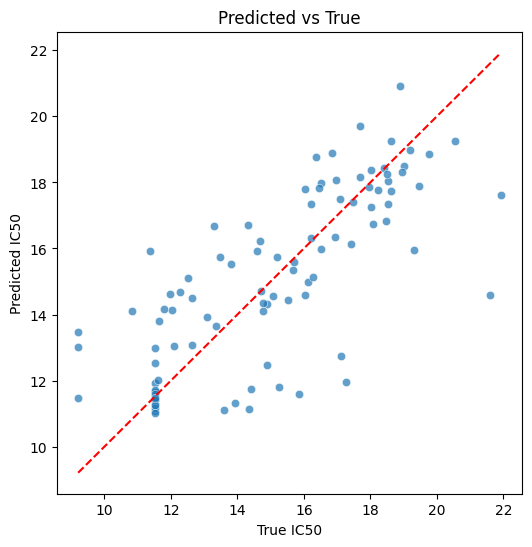

Training and evaluation complete
Training SVM model for classification using genetic_algorithm features...
Running 5-fold cross-validation for SVM (classification)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 0.8018
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 0.7477
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 0.7928
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 0.7658
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 0.7027
Average Cross-Validation Metric: 0.7622
Test Metric: 0.8283


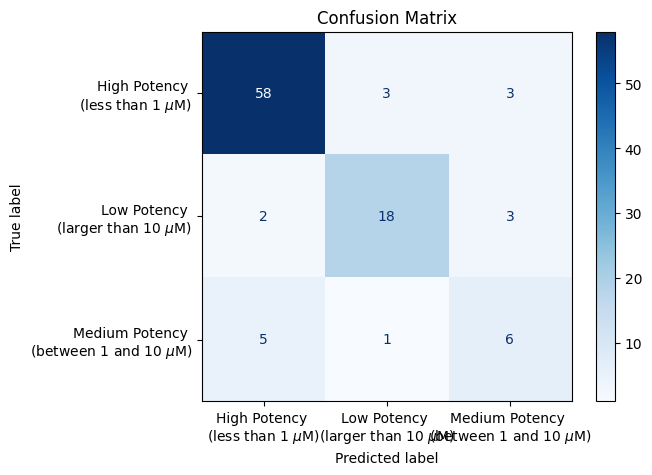

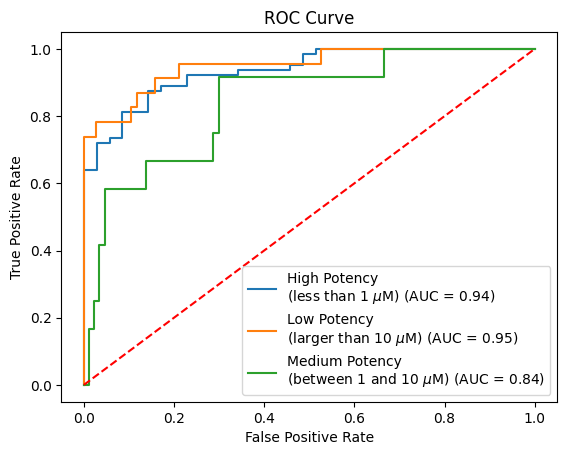

Training and evaluation complete
Training SVM model for regression using genetic_algorithm features...
Running 5-fold cross-validation for SVM (regression)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 1 - Best Model Metric: 9.1662
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 2 - Best Model Metric: 8.8185
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 3 - Best Model Metric: 9.0995
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 4 - Best Model Metric: 11.2534
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 5 - Best Model Metric: 8.2958
Average Cross-Validation Metric: 9.3267
Test Metric: 11.5616


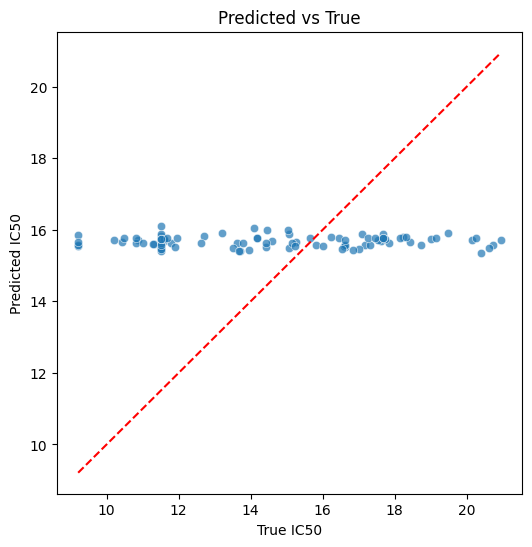

Training and evaluation complete


In [6]:
for input_type in input_types:
    for problem_type in problem_types:
        print(f"Training SVM model for {problem_type} using {input_type} features...")
        results = run_svm(problem_type=problem_type, input_type=input_type, seed=seed)
        
        # Unpack results
        final_model = results["best_model"]
        X_test = results["X_test"]
        y_test = results["y_test"]
        
        print("Training and evaluation complete")